In [1]:
import numpy as np

def criaDatasetBidimensionalBinárioInclinado(n=20, slop=[2, 1], intercept=0.4):
    """
    Cria um dataset bidimensional binário com
    inclinação e interceptação do eixo vertical
    parametrizados.
    """
    X = np.random.uniform(size=(n,2))*5
    AUX = np.multiply(X, slop)-[0, intercept]
    y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
    return X, y

slop = [2, 1]
intercept = -0.4
Xtr, ytr = criaDatasetBidimensionalBinárioInclinado(n=20, slop=slop, intercept=intercept)
Xtr, ytr

(array([[0.88863751, 2.68523199],
        [1.29943143, 1.40500735],
        [4.57506179, 3.84214416],
        [1.84876195, 0.03585142],
        [0.13311683, 0.55305375],
        [0.18441521, 4.61067152],
        [3.98167808, 1.42185648],
        [0.5185807 , 4.20865482],
        [1.26344038, 0.48171765],
        [4.39467178, 0.94347431],
        [4.86708361, 3.75997754],
        [0.96097249, 4.28933408],
        [1.02727759, 0.78378403],
        [3.25748151, 4.51981235],
        [0.63327403, 3.8646875 ],
        [1.23566742, 1.74547954],
        [4.84770437, 0.13087809],
        [2.63375349, 2.53248774],
        [0.51367098, 4.30305461],
        [2.22062765, 3.89336816]]),
 array([-1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,
         1, -1,  1]))

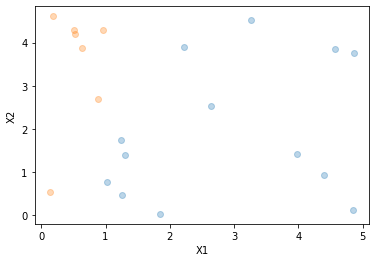

In [2]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

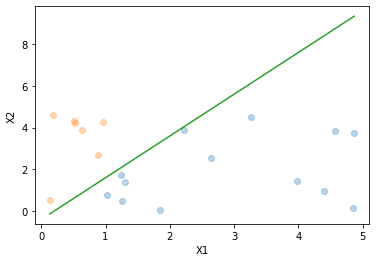

In [3]:
def plotaHiperplanoDatasetBidimensional(X, y, vetor, intercept=0):
    """
    Plota um dataset bidimensional com um hiperplano definido por um
    vetor e o valor em que este vetor intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array(slop) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, ytr, vetor_hyperplano, intercept)

In [4]:
def sign(a):
    return (a >= 0) * 2 - 1

In [5]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [6]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [7]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y, activation):
        pass

class DescidaGradiente(TrainingAlgorithm):
    def __init__(self, max_iter=1000, learning_rate=0.005, 
                       regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.cost = cost

    def getW(self, X, y):
        w = np.random.uniform(-1, 1, size=X.shape[1])
        for _ in range(self.max_iter):
            ypred = X @ w
            if self.cost.custo(y, ypred) == 0:
                break
            w *= 1 - self.regularization * self.learning_rate
            w += self.cost.gradiente(y, ypred, X) * self.learning_rate
        return w

1.0
[-1.05114322  5.54383416 -2.11848012]
36.32695729923543


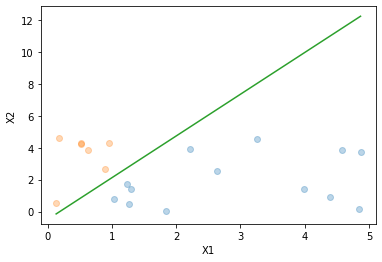

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Perceptron(BaseEstimator, ClassifierMixin):
    """
    Versão Adaline do Perceptron com limite de iterações,
    treinado em batch, com bias e taxa de aprendizado.
    """
    def __init__(self, training_algorithm=DescidaGradiente()):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def fit(self, X, y):
        Xb = Perceptron.includebias(X)
        self.w = self.training_algorithm.getW(Xb, y)
    
    def __pre_activation(self, X):
        Xb = Perceptron.includebias(X)
        return Xb @ self.w

    def predict(self, X):
        a = self.__pre_activation(X)
        ypred = self.activation(a)
        return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)
plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
print(sum(perceptron.w**2))

In [9]:
Xte, yte = criaDatasetBidimensionalBinárioInclinado(n=1000, slop=slop, intercept=intercept)

1.0 0.97 [ 0.06090298  0.37516139 -0.21408919]


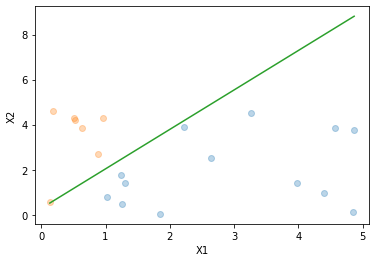

1.0 0.922 [-0.21521425  0.35726653 -0.08481099]


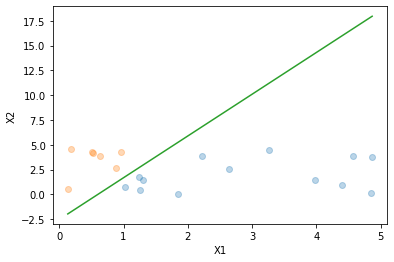

1.0 0.949 [-0.82624052  2.95457707 -1.04353369]


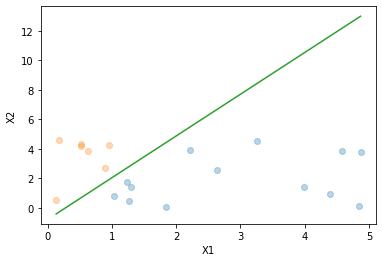

1.0 0.95 [-0.97116387  5.48821157 -2.12507571]


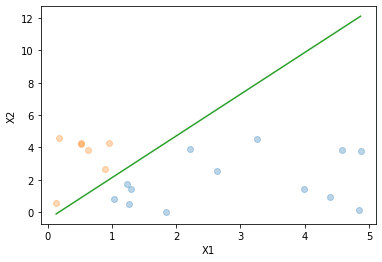

In [10]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    perceptron = Perceptron(training_algorithm=DescidaGradiente(regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)), perceptron.w)
    plotaDatasetBidimensional(Xtr, ytr)
    plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
    plt.show()
